In [45]:
import numpy as np
import operator
from matplotlib import pylab as plt
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [46]:
try:
    train_df = pd.read_json("/home/gs/DataScientist/twosigma/train.json")
    test_df = pd.read_json("/home/gs/DataScientist/twosigma/test.json")
except:
    train_df = pd.read_json("/home/ec2-user/DataScientist/twosigma/train.json")
    test_df = pd.read_json("/home/ec2-user/DataScientist/twosigma/test.json")


In [ ]:
train_df.head()

In [48]:
print (train_df['longitude'] [train_df['longitude'] < -75 ])
print (train_df['longitude'] [train_df['longitude'] == 0 ])
print (train_df['longitude'].describe())

train_df.ix[train_df['longitude'] < -75, 'longitude'  ] = -73.9779
train_df.ix[train_df['longitude'] == 0, 'longitude'  ] = -73.9779


Series([], Name: longitude, dtype: float64)
Series([], Name: longitude, dtype: float64)
count    49352.000000
mean       -73.971783
std          0.054004
min        -74.663700
25%        -73.991700
50%        -73.977900
75%        -73.954800
max        -70.984600
Name: longitude, dtype: float64


In [52]:
print (train_df['latitude'] [train_df['latitude'] < 34 ])
print (train_df['latitude'] [train_df['latitude'] == 0 ])
print (train_df['latitude'].describe())

train_df.ix[train_df['latitude'] < 34, 'latitude'  ] = 40.7518
train_df.ix[train_df['latitude'] == 0, 'latitude'  ] = 40.7518


Series([], Name: latitude, dtype: float64)
Series([], Name: latitude, dtype: float64)
count    49352.000000
mean        40.751454
std          0.063409
min         34.012600
25%         40.728300
50%         40.751800
75%         40.774300
max         44.883500
Name: latitude, dtype: float64


In [3]:
#basic features
#train_df.loc[train_df.loc[:,"bedrooms"] == 0, "bedrooms"] = 1
train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
#test_df.loc[test_df.loc[:,"bedrooms"] == 0, "bedrooms"] = 1
test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 

train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# create time, interval time from since the list created
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["passed"] = train_df["created"].max() - train_df["created"]
train_df["passed"] = train_df["passed"].dt.days

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["passed"] = test_df["created"].max() - test_df["created"]
test_df["passed"] = test_df["passed"].dt.days

train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","price_t",
"num_photos", "num_features", "num_description_words","listing_id", "created_year", "created_month", "created_day", "created_hour"]


In [4]:
#transfer the categorical varibles to label integer
categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)


In [ ]:
train_df.head()

In [5]:
train_X = train_df[features_to_use]
test_X = test_df[features_to_use]


target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape, train_y.shape)


((49352, 17), (74659, 17), (49352,))


In [14]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20, verbose_eval=100)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds, verbose_eval=100)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model



[0]	train-mlogloss:1.08925	test-mlogloss:1.08937
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[100]	train-mlogloss:0.79437	test-mlogloss:0.807978
[200]	train-mlogloss:0.764416	test-mlogloss:0.792321
Stopping. Best iteration:
[260]	train-mlogloss:0.755042	test-mlogloss:0.791819

[0.79195696059244181]


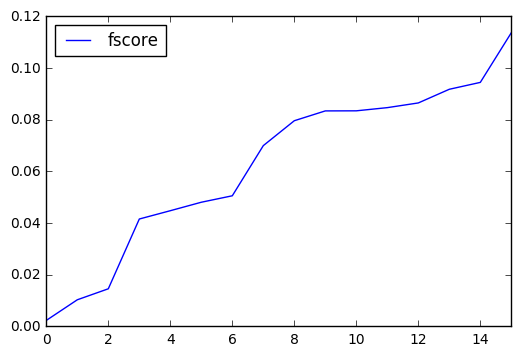

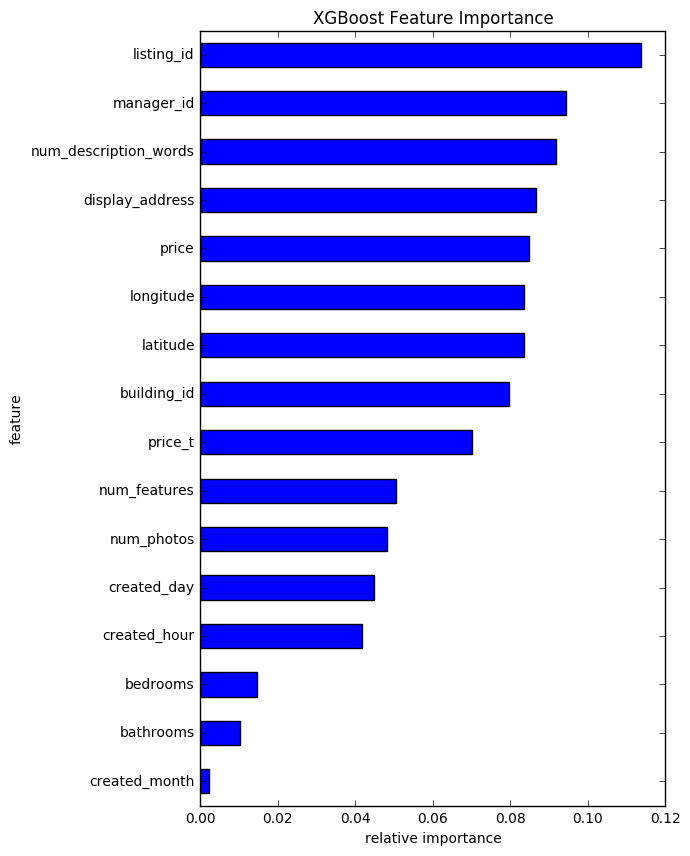

[('created_month', 72), ('bathrooms', 318), ('bedrooms', 449), ('created_hour', 1281), ('created_day', 1380), ('num_photos', 1481), ('num_features', 1558), ('price_t', 2156), ('building_id', 2453), ('latitude', 2570), ('longitude', 2571), ('price', 2609), ('display_address', 2665), ('num_description_words', 2828), ('manager_id', 2910), ('listing_id', 3502)]
0.791956960592


In [25]:
cv_scores = []
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    #print (type(dev_index))
    #print (dev_index)
    dev_X, val_X = train_X.ix[dev_index], train_X.ix[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)

    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))
    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()
    plt.figure()
    df.plot()
    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.show()
    
    print (importance)
    break
print (np.mean(cv_scores))

In [ ]:
#final prediction
preds, model = runXGB(train_X, train_y, test_X, num_rounds=100)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("SUB_02.csv", index=False)
